In [4]:
from __future__ import print_function
from __future__ import division

import sys
import torch
import torch.utils.data as dataF
import os
import time
import pickle
import numpy as np
from PIL import Image
import PIL
import re
import io

import json
import matplotlib
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim

import itertools
import collections
import pdb
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
cuda

False

### Common utils

In [5]:
# Path for file dset_dataloader.json
def open_json(path):
    f = open(path) 
    data = json.load(f) 
    f.close()
    return data 

def save_json(file_path, data):
    out_file = open(file_path, "w")
    json.dump(data, out_file)
    out_file.close()

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

#### Bar to visualize progress

In [3]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

#### Paths and files

In [6]:
# IMAGES
im_path_fur = '../../../../ADARI/images/ADARI_v2/furniture/full'

# ONEHOTS
onehots_vocab_p = '../../../../ADARI/json_files/cleaned/ADARI_v2/furniture/ADARI_furniture_onehots_vocab_3labels.json'
onehots_w2i_p = '../../../../ADARI/json_files/cleaned/ADARI_v2/furniture/ADARI_furniture_onehots_w2i_3labels.json'
onehots_i2w_p = '../../../../ADARI/json_files/cleaned/ADARI_v2/furniture/ADARI_furniture_onehots_i2w_3labels.json'
onehots_p = '../../../../ADARI/json_files/cleaned/ADARI_v2/furniture/ADARI_furniture_onehots_3labels.json'

In [7]:
# Open json files with embeddings 
onehots = open_json(onehots_p)
onehots_vocab = open_json(onehots_vocab_p)
onehots_w2i = open_json(onehots_w2i_p)
onehots_i2w = open_json(onehots_i2w_p)

In [8]:
len(onehots_vocab)

4780

In [7]:
onehots_vocab

{'danish': 243,
 'recycled': 210,
 'outdoor': 209,
 'japanese': 189,
 'swedish': 159,
 'plastic': 141,
 'public': 140,
 'solid': 140,
 'chinese': 138,
 'concrete': 138,
 'nordic': 137,
 'norwegian': 127,
 'urban': 122,
 'bent': 121,
 'modular': 118,
 'traditional': 118,
 'brazilian': 112,
 'tubular': 111,
 'digital': 108,
 'flat-pack': 104,
 'raw': 101,
 'original': 100,
 'coloured': 100,
 'architectural': 95,
 'red': 93,
 'australian': 91,
 'french': 88,
 'korean': 86,
 'local': 86,
 'white': 85,
 'pink': 84,
 'industrial': 82,
 'italian': 82,
 'dutch': 81,
 'domestic': 80,
 'mexican': 80,
 'ceramic': 79,
 'unseen': 78,
 'young': 78,
 'african': 77,
 'finnish': 77,
 'mid-century': 77,
 'black': 76,
 'transparent': 76,
 'lacquered': 76,
 'yellow': 75,
 'english': 75,
 'offsite': 74,
 'steam-bent': 74,
 'human': 73,
 'environmental': 72,
 'contemporary': 69,
 'textile': 69,
 'perforated': 68,
 'online': 67,
 'grey': 65,
 'future': 65,
 'cantilevered': 65,
 'polished': 64,
 'german': 63,

In [8]:
onehots_w2i

{'well-priced': 0,
 'modern': 1,
 'country-friendly': 2,
 'work-from-home': 3,
 'glossy': 4,
 'green-stained': 5,
 'modulus': 6,
 'fermented': 7,
 'predominant': 8,
 'able': 9,
 'lesser-used': 10,
 'baked': 11,
 'mirrored': 12,
 'high-quality': 13,
 'asymmetric': 14,
 'outdoor': 15,
 'versatile': 16,
 'weatherproof': 17,
 'chinese': 18,
 'international': 19,
 'fair': 20,
 'eco-package': 21,
 'corrugated-cardboard': 22,
 'corporate': 23,
 'boundary': 24,
 'ornamental': 25,
 'conceptual': 26,
 'environmental': 27,
 'non-recyclable': 28,
 'charitable': 29,
 'healthy': 30,
 'comfortable': 31,
 'professional': 32,
 'black-dyed': 33,
 'dog-themed': 34,
 'hollywood-style': 35,
 'classical': 36,
 'musical': 37,
 'pandemic-friendly': 38,
 'hand-drawn': 39,
 'hyper-real': 40,
 'soft-open': 41,
 'functional': 42,
 'placid': 43,
 'exquisite': 44,
 'post-industrialised': 45,
 'custom-dyed': 46,
 'wholesome': 47,
 'air-dried': 48,
 'environmentally-friendly': 49,
 'antibacterial': 50,
 'smart': 51,


In [8]:
def create_unbalanced_weights(vocab, w2i):
    all_labels = sum(vocab.values())
    weights = [0]*len(w2i)
    for k, val in w2i.items():
        weights[val] = vocab[k] / all_labels
    return torch.FloatTensor(weights).to(device)

In [9]:
LABEL_WEIGHTS = create_unbalanced_weights(onehots_vocab, onehots_w2i)

### DATASET

#### Split dataset into train, validation and test

In [6]:
import random

def shuffle_dict(d):
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)
    return d

def splitDict(d_img_words, percent, val_number):

    val_n = val_number
    train_test_size = len(d_img_words) - val_n
    train_n = int(train_test_size*percent)
    test_n = train_test_size - train_n
    
    d_img_words = shuffle_dict(d_img_words)
    im_words = iter(d_img_words.items())      
    
    # Image - words
    dtrain_imw = dict(itertools.islice(im_words, train_n))  
    dtest_imw = dict(itertools.islice(im_words, test_n))   
    dval_imw = dict(itertools.islice(im_words, val_n))
    
    
    print('trainset size: ', len(dtrain_imw), 'test dataset size: ',len(dtest_imw), 'val set size: ', len(dval_imw))
    return dtrain_imw, dtest_imw, dval_imw 

In [7]:
dtrain_w, dtest_w, dval_w = splitDict(onehots, .8, 1000)

trainset size:  13225 test dataset size:  3307 val set size:  1000


#### Save train test and val sets in json files

In [11]:
# save_json('./train_test_val_multilabel/trainset_3l.json', dtrain_w)
# save_json('./train_test_val_multilabel/testset_3l.json', dtest_w)
# save_json('./train_test_val_multilabel/valset_3l.json', dval_w)

In [9]:
dtrain_w = open_json('./train_test_val_dataset_splits/trainset_3l.json')
dtest_w = open_json('./train_test_val_dataset_splits/testset_3l.json')
dval_w = open_json('./train_test_val_dataset_splits/valset_3l.json')

#### Dataset class

In [12]:
class MyDataset(Dataset):
    def __init__(self, onehots, w2i, i2w, image_path):
        self.onehots_d = onehots
        self.w2i = w2i
        self.i2w = i2w
        self.images_names = list(self.onehots_d.keys()) # names
        self.onehots = list(self.onehots_d.values()) # onehots
        self.image_path = image_path
    
    def __len__(self):
        return len(self.onehots)
    
    def get_image_tensor(self, image_name):
        """
        Gets image name and returns a tensor
        """
        name = self.image_path + "/" + image_name
        img = Image.open(name)
        img = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor()])(img)
        
        return img

    def __getitem__(self, index):
        name_image = self.images_names[index]
        img = self.get_image_tensor(name_image)
        onehot = torch.FloatTensor(self.onehots[index])
        
        return img, onehot, name_image

In [13]:
dataset_train = MyDataset(dtrain_w, onehots_w2i, onehots_i2w, im_path_fur)
dataset_test = MyDataset(dtest_w, onehots_w2i, onehots_i2w,im_path_fur)
dataset_val = MyDataset(dval_w, onehots_w2i, onehots_i2w,  im_path_fur)

In [14]:
batch_size = 64
num_workers = 8 if cuda else 0

In [15]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)


In [46]:
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

In [17]:
# to test dataloader
it = iter(test_dataloader)
print(next(it))


[tensor([[[[0.9647, 0.9647, 0.9647,  ..., 0.9451, 0.9451, 0.9451],
          [0.9569, 0.9647, 0.9608,  ..., 0.9451, 0.9451, 0.9451],
          [0.9608, 0.9529, 0.9451,  ..., 0.9451, 0.9451, 0.9451],
          ...,
          [0.9725, 0.9725, 0.9725,  ..., 0.9137, 0.9059, 0.8902],
          [0.9725, 0.9686, 0.9686,  ..., 0.9137, 0.9059, 0.8863],
          [0.9686, 0.9725, 0.9686,  ..., 0.9137, 0.9059, 0.8824]],

         [[0.9647, 0.9647, 0.9647,  ..., 0.9451, 0.9451, 0.9451],
          [0.9686, 0.9647, 0.9647,  ..., 0.9451, 0.9451, 0.9451],
          [0.9255, 0.8980, 0.8902,  ..., 0.9451, 0.9451, 0.9451],
          ...,
          [0.9725, 0.9725, 0.9686,  ..., 0.9059, 0.9020, 0.8431],
          [0.9725, 0.9686, 0.9647,  ..., 0.9059, 0.9020, 0.8353],
          [0.9686, 0.9725, 0.9647,  ..., 0.9059, 0.9059, 0.8314]],

         [[0.9647, 0.9647, 0.9608,  ..., 0.9451, 0.9451, 0.9451],
          [0.9608, 0.9647, 0.9725,  ..., 0.9451, 0.9451, 0.9451],
          [0.8745, 0.8275, 0.8157,  ..., 

### MODEL

In [16]:
feature_extract = False # so we update the whole model 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract) # This line is for finetuning vs feature extraction
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 64
    
    return model_ft, input_size

In [18]:
num_classes = len(onehots_w2i)
model, input_size = initialize_model(num_classes, feature_extract)
model.fc.weight.shape
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training

In [19]:
from sklearn.metrics import precision_score, f1_score, accuracy_score, label_ranking_average_precision_score, average_precision_score, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from torch.optim import lr_scheduler

device = torch.device("cuda" if cuda else "cpu")
model = model.to(device)
# Without label weights
criterion = nn.BCEWithLogitsLoss()
# With label weights
#criterion = nn.BCEWithLogitsLoss(pos_weight=LABEL_WEIGHTS)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005)
plateau = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [14]:
def train_epoch(model, loader, optimizer, criterion, scheduler):
    model.train()
    running_loss = 0.0
    
    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0
    running_auc = 0.0
    
    running_corrects_ = 0.0
    running_precision_ = 0.0
    running_accuracy_ = 0.0
    running_auc_ = 0.0
    
    result = []
    result_ = []
    start_time = time.time()
    for batch_idx, (image, target) in enumerate(loader):   
        image = image.to(device)
        target = target.to(device)
        output = model(image)
        loss = criterion(output, target) # Averaging losses from all vector components. 

        # We use sigmoid for prediction. Sigmoid is applied to each individual class in the 2700 classes. 
        # Therefore, if it's more than 0.5, we predict it as True. 
        preds = torch.sigmoid(output).data > 0.5
        preds = preds.to(torch.float32)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()   
        
        running_loss += loss.item() * image.shape[0]
        
        # Metrics 
        SAMPLE_WEIGHT = compute_sample_weight('balanced', target.to("cpu"))
        
        f1 = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples", sample_weight=SAMPLE_WEIGHT)*image.size(0)
        precision = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples",sample_weight=SAMPLE_WEIGHT)*image.size(0)
        accuracy = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(),sample_weight=SAMPLE_WEIGHT)*image.size(0)
        auc = roc_auc_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples", sample_weight=SAMPLE_WEIGHT)*image.size(0)
        
        f1_ = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
        precision_ = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
        accuracy_ = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*image.size(0)
        auc_ = roc_auc_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
        
        running_corrects += f1
        running_precision += precision
        running_accuracy += accuracy
        running_auc += auc
        
        running_corrects_ += f1_
        running_precision_ += precision_
        running_accuracy_ += accuracy_
        running_auc_ += auc_

    end_time = time.time()
    epoch_loss = running_loss / len(loader.dataset)
    
    epoch_f1 = running_corrects / len(loader.dataset)
    epoch_precision = running_precision / len(loader.dataset)
    epoch_acc = running_accuracy / len(loader.dataset)
    epoch_auc = running_auc / len(loader.dataset)
    
    epoch_f1_ = running_corrects_ / len(loader.dataset)
    epoch_precision_ = running_precision_ / len(loader.dataset)
    epoch_acc_ = running_accuracy_ / len(loader.dataset)
    epoch_auc_ = running_auc_ / len(loader.dataset)
    
    result.append('WEIGHTED Training Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f} AUC: {:.4f}'.format(epoch_loss, epoch_f1, epoch_acc, epoch_precision, epoch_auc))
    print(result)
    result_.append('UNWEIGHTED Training Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f} AUC: {:.4f}'.format(epoch_loss, epoch_f1_, epoch_acc_, epoch_precision_, epoch_auc_))
    print(result_)
    
    return epoch_loss, epoch_f1, result

In [15]:
def test_epoch(model, loader, criterion):
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0
    running_auc = 0.0
    
    running_corrects_ = 0.0
    running_precision_ = 0.0
    running_accuracy_ = 0.0
    running_auc_ = 0.0
    
    result = []
    result_ = []
    with torch.no_grad():
        for batch_idx, (image, target) in enumerate(loader):   
            image = image.to(device)
            target = target.to(device)

            output = model(image)
            loss = criterion(output, target)

            preds = torch.sigmoid(output).data > 0.5
            preds = preds.to(torch.float32)

            running_loss += loss.item() * image.shape[0]
            
            # Metrics 
            SAMPLE_WEIGHT = compute_sample_weight('balanced', target.to("cpu"))
            
            f1 = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples", sample_weight=SAMPLE_WEIGHT)*image.size(0)
            precision = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples",sample_weight=SAMPLE_WEIGHT)*image.size(0)
            accuracy = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(),sample_weight=SAMPLE_WEIGHT)*image.size(0)
            auc = roc_auc_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples", sample_weight=SAMPLE_WEIGHT)*image.size(0)

            f1_ = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
            precision_ = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
            accuracy_ = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*image.size(0)
            auc_ = roc_auc_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
             
            running_corrects += f1
            running_precision += precision
            running_accuracy += accuracy
            running_auc += auc
            
            running_corrects_ += f1_
            running_precision_ += precision_
            running_accuracy_ += accuracy_
            running_auc_ += auc_

        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = running_corrects / len(loader.dataset)
    epoch_precision = running_precision / len(loader.dataset)
    epoch_acc = running_accuracy / len(loader.dataset)
    epoch_auc = running_auc / len(loader.dataset)
    
    epoch_f1_ = running_corrects_ / len(loader.dataset)
    epoch_precision_ = running_precision_ / len(loader.dataset)
    epoch_acc_ = running_accuracy_ / len(loader.dataset)
    epoch_auc_ = running_auc_ / len(loader.dataset)
    

    result.append('WEIGHTED Testing Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f} AUC: {:.4f}'.format(epoch_loss, epoch_f1, epoch_acc, epoch_precision, epoch_auc))
    print(result)
    result_.append('UNWEIGHTED Testing Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f} AUC: {:.4f}'.format(epoch_loss, epoch_f1_, epoch_acc_, epoch_precision_, epoch_auc_))
    print(result_)
    
    return epoch_loss, epoch_f1, result

In [24]:
len(train_dataloader.dataset), len(test_dataloader.dataset)

(13225, 3307)

In [18]:
def createCheckpoint(filename, batch_size, epoch):
    checkpoint = {
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
    } # save all important stuff
    torch.save(checkpoint , filename)

In [19]:
import warnings
warnings.filterwarnings(action='ignore')

In [31]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
train_results = []
test_results = []
diff_train_test_losses = [1000]

save_model_path = './saved_models/multilabel_adam0.001_resnet_pretrained_3labels/'
if os.path.isdir(save_model_path) == False:
    os.makedirs(save_model_path)
    print("Directory '%s' created" %save_model_path)
epochs=50
best_loss = 1000.0
for i in range(epochs):
    print('-----Training epoch {}/{} --------'.format(i,epochs-1))
    tr_loss, tr_acc, tr_res = train_epoch(model, train_dataloader, optimizer, criterion, sgdr_partial)
    print('train epoch: {}, loss: {}'.format(i, tr_loss))
    print('------Testing epoch {}/{} --------'.format(i,epochs-1))
    tst_loss, tst_acc, tst_res = test_epoch(model, test_dataloader, criterion)
    print('test epoch: {}, loss: {}'.format(i, tst_loss))
    print()
    
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    test_losses.append(tst_loss)
    test_accs.append(tst_acc)
    
    train_results += tr_res
    test_results += tst_res
    
    diff_train_test = np.absolute(tr_loss-tst_loss)
    
    if i > 10:
        # if loss decreases
        if tst_loss < best_loss:
            best_loss = tst_loss
            save_path_resnet = save_model_path + 'resnet_{}.pt'.format(i)
            createCheckpoint(save_path_resnet, 64, i)

        # if difference between train and test is smaller, save
        elif diff_train_test < diff_train_test_losses[-1]:
            save_path_resnet = save_model_path + 'resnet_{}.pt'.format(i)
            createCheckpoint(save_path_resnet, 64, i)
    
    diff_train_test_losses.append(diff_train_test)
    

Directory './saved_models/multilabel_adam0.001_resnet_pretrained_3labels/' created
-----Training epoch 0/49 --------
['WEIGHTED Training Loss: 0.0116 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.5000']
['UNWEIGHTED Training Loss: 0.0116 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.5001']
train epoch: 0, loss: 0.011577212941640942
------Testing epoch 0/49 --------
['WEIGHTED Testing Loss: 0.0050 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.5000']
['UNWEIGHTED Testing Loss: 0.0050 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.5000']
test epoch: 0, loss: 0.005038321095524118

-----Training epoch 1/49 --------
['WEIGHTED Training Loss: 0.0050 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.5000']
['UNWEIGHTED Training Loss: 0.0050 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.5000']
train epoch: 1, loss: 0.00499233262940875
------Testing epoch 1/49 --------
['WEIGHTED Testing Loss: 0.0050 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.5000']
['UNWEIGHTED Testing Loss: 0.0050 F1: 0.0000 Acc: 0.0000 Prec: 0.0000

In [20]:
# save_model_path = './saved_models/multilabel_adam0.001_resnet_pretrained_3labels/'
# save_path_resnet = save_model_path + 'resnet_last_epoch.pt'
# createCheckpoint(save_path_resnet, 64, 49)

### Load checkpoint

In [21]:
save_model_path = './pretrained/saved_models/v3_3labels/'
checkpoint = torch.load(save_model_path + "resnet_28.pt", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

In [22]:
def make_graph(epochs, train, test, train_name, val_name, name_long, name_short):
    plt.plot(epochs, train, 'g', label=train_name, c="mediumvioletred")
    plt.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    plt.title(name_long)
    plt.xlabel('Epochs')
    plt.ylabel(name_short)
    plt.legend()
    plt.savefig('ADARI_resnet152_pretrained_adam0001.pdf', dpi=300)
    plt.savefig('ADARI_resnet152_pretrained_adam0001.png', dpi=300)
    plt.show()
    

In [35]:
epochs_list = [e for e in range(epochs)]

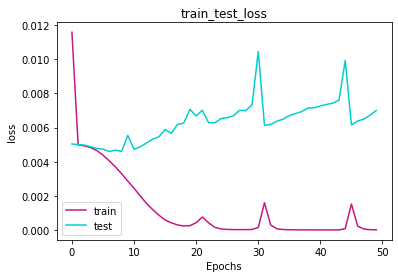

In [36]:
make_graph(epochs_list, train_losses, test_losses, 'train', 'test', 'train_test_loss', 'loss')

In [37]:
with open("train_losses", "w") as outfile:
    outfile.write("\n".join(str(item) for item in train_losses))
with open("test_losses", "w") as outfile:
    outfile.write("\n".join(str(item) for item in test_losses))